In [33]:
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import glob
import os
import cv2
import argparse
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as kr
from keras import backend as K
from keras.layers.merge import concatenate
from matplotlib import cm
from skimage import io as skio
from skimage import io, transform, img_as_float 

image_height = 128
image_width = 128

def train_id_to_path(x):
    return 'SAXSdata1/' + str(x) + ".tif"
#def test_id_to_path(x):
    #return 'SAXSdata/' + x + ".tif"

def path_to_eagertensor(image_path):
    image = cv2.imread(image_path)
    image = tf.image.rgb_to_grayscale(image)
    image = tf.cast(image, tf.float32) / 255.0
    #image = tf.image.resize_with_pad(image, image_height, image_width) #optional with padding to retain original dimensions
    image = tf.image.resize(image, (image_height, image_width))
    return image

def int_to_float(image_path):
    image = io.imread(image_path)   #读取图像为整型， [0-255]
    image = img_as_float(image)  #变为浮点型[0-1]。
    image = (image - image.min()) * (1 / (image.max() - image.min()))  #比例缩放的归一化
    image = transform.resize(image, (image_height, image_width))  #图像缩放大小
    return image

def plot_predictions(y_true, y_pred):    
    f, ax = plt.subplots(2, 10, figsize=(15, 4))
    for i in range(10):
        ax[0][i].imshow(np.reshape(y_true[i], (128, 128)), aspect='auto')
        ax[1][i].imshow(np.reshape(y_pred[i], (128, 128)), aspect='auto')
    plt.tight_layout()
    
def getdata():
    cols = ["id", "tem", "strain", "area"]
    df = pd.read_csv("SAXSdata1/saxsdata1.dat", sep=" ", header=None, names=cols)
    df["img_path"] = df["id"].apply(train_id_to_path)
    X = []
    Y = df[["tem","strain"]]
   
    for img in df['img_path']:
        new_img_tensor = path_to_eagertensor(img)
        X.append(new_img_tensor)
    
    X = np.array(X)
    Y = np.array(Y)
    print(type(X),X.shape)
    print(type(X),Y.shape)
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.05, random_state=42)
    print(type(x_train),x_train.shape)
    print(type(x_test),x_test.shape)
    print(type(y_train),y_train.shape)
    print(type(y_test),y_test.shape)
    return x_train, x_test, y_train, y_test

def plot_digits(X, y, s, encoder):
    """Plots labels and MNIST digits as function of 2D latent vector

    Parameters:
    ----------
    encoder: Model
        A Keras Model instance
    X: np.ndarray
        Test data
    y: np.ndarray
        Test data labels
    batch_size: int
        Prediction batch size
    """
    # display a 2D plot of the digit classes in the latent space
    z_mean = encoder.predict([X,y])
    plt.figure(figsize=(20, 10))
    plt.scatter(z_mean, y, c = s,cmap = 'plasma')
    plt.colorbar()
    my_x_ticks = np.arange(-4,4,0.5)
    plt.xticks(my_x_ticks)
    plt.xlabel("Latent Dimension")
    plt.ylabel("tem")
    plt.show()
    
def plot_digits1(s, y, X, encoder):
    """Plots labels and MNIST digits as function of 2D latent vector

    Parameters:
    ----------
    encoder: Model
        A Keras Model instance
    X: np.ndarray
        Test data
    y: np.ndarray
        Test data labels
    batch_size: int
        Prediction batch size
    """
    # display a 2D plot of the digit classes in the latent space
    z_mean = encoder.predict([X,y])
    plt.figure(figsize=(15, 10))
    plt.scatter(s, y, c = z_mean,cmap = 'plasma')
    plt.colorbar()
    plt.xlabel("strain")
    plt.ylabel("tem")
    plt.show()
    
def plot_digits2(X, s, y, encoder):
    """Plots labels and MNIST digits as function of 2D latent vector

    Parameters:
    ----------
    encoder: Model
        A Keras Model instance
    X: np.ndarray
        Test data
    y: np.ndarray
        Test data labels
    batch_size: int
        Prediction batch size
    """
    # display a 2D plot of the digit classes in the latent space
    z_mean = encoder.predict([X,y])
    plt.figure(figsize=(15, 10))
    plt.scatter(s, z_mean, c = y,cmap = 'plasma')
    cb=plt.colorbar()
    cb.ax.tick_params(labelsize=16)
    cb.ax.set_xlabel('tem', size=20)
    plt.xlabel("strain",fontsize = 20)
    plt.ylabel("Latent Dimension",fontsize = 20)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    #plt.savefig(r"C:\Users\zch\Desktop\7.1\数据整理\CVAE-2")
    plt.show()

def Perdict_tem(t, s, a, b, decoder):
    ndiv = s # number of images for axis
    tem = 1
    gx = np.linspace(a,b,ndiv)
    l = [[t]]
    l = np.array(l)
    gxx, gyy = np.meshgrid(gx, l[::-1])
    gxx = gxx.reshape(-1,1)
    gyy = gyy.reshape(-1,1)
    x = decoder.predict([gxx,gyy])
    dst = x.reshape(tem,ndiv,128,128)
    dst = dst.transpose(0,2,1,3)
    dst = dst.reshape(tem*128, ndiv*128)
    plt.imshow(dst)
    plt.tight_layout();plt.show()
    return dst

def Perdict_all(t, s, a, b, tmax, tmin, decoder):
    ndiv = s # number of images for axis
    tem = t
    gx = np.linspace(a, b, ndiv)
    l = np.linspace(tmin, tmax, tem)
    gxx, gyy = np.meshgrid(gx, l[::-1])
    gxx = gxx.reshape(-1,1)
    gyy = gyy.reshape(-1,1)
    x = decoder.predict([gxx,gyy])
    dst = x.reshape(tem,ndiv,128,128)
    dst = dst.transpose(0,2,1,3)
    dst = dst.reshape(tem*128, ndiv*128)
    plt.imshow(dst)
    plt.tight_layout();plt.show()
    return dst

In [34]:
class CVAE():
    def __init__(self):

        self.input_dim = 128*128
        self.latent_dim = 1
        self.label_dim = 1
        nch = 512
        
        self.inputs = kr.Input(shape=(self.input_dim,))
        self.label_input_enc = kr.Input(shape=(self.label_dim,))
        self.label_input_dec = kr.Input(shape=(self.label_dim,))
                
        x = concatenate([self.inputs, self.label_input_enc])
        x = kr.layers.Dense(nch, activation='relu')(x)
        x = kr.layers.Dense(256, activation='relu')(x)
        #lx = kr.layers.Dense(nch, activation='relu')(self.label_input_enc)
        #x = concatenate([x, lx])
        x = kr.layers.Dense(128, activation='relu')(x)
        x = kr.layers.Dense(64, activation='relu')(x)

        # shape info needed to build decoder model
        self.shape = x.get_shape().as_list()

        #x = kr.layers.Dense(16, activation='relu')(x)
        self.z_mean = kr.layers.Dense(self.latent_dim)(x)
        self.z_log_var = kr.layers.Dense(self.latent_dim)(x)
        self.z = kr.layers.Lambda(self.sampling, output_shape=(self.latent_dim,))([self.z_mean, self.z_log_var])
        
        # build decoder model
        #latent_inputs = kr.Input(shape=(latent_dim,), name='z_sampling')
        self.dec1 = kr.layers.Dense(64, activation='relu')
        #self.dec1_label = kr.layers.Dense(self.latent_dim, activation='relu')
        self.dec2 = kr.layers.Dense(128, activation='relu')
        self.dec3 = kr.layers.Dense(256, activation='relu')
        self.dec4 = kr.layers.Dense(nch, activation='relu')
        self.dec_out = kr.layers.Dense(self.input_dim, activation='sigmoid')
        
        x = concatenate([self.z, self.label_input_dec])
        #lx = self.dec1_label(self.label_input_dec)
        #x = concatenate([self.z, lx])
        x = self.dec1(x)
        x = self.dec2(x)
        x = self.dec3(x)
        x = self.dec4(x)
        self.outputs = self.dec_out(x)   
        
    # sampling function
    def sampling(self, args):
        z_mean, z_log_var = args
        nd = K.shape(z_mean)[0]
        nc = self.latent_dim
        eps = K.random_normal(shape=(nd, nc), mean=0., stddev=1.0)
        return z_mean + K.exp(z_log_var / 2) * eps

    def cvae(self):
        return kr.Model([self.inputs, self.label_input_enc, self.label_input_dec], self.outputs)

    def encoder(self):
        return kr.Model([self.inputs, self.label_input_enc], self.z_mean)
   
    def decoder(self):
        z = kr.Input(shape=(self.latent_dim,))
        l = kr.Input(shape=(self.label_dim,))
        x = concatenate([z,l])
        x = self.dec1(x)
        x = self.dec2(x)
        x = self.dec3(x)
        x = self.dec4(x)
        x_out = self.dec_out(x)  
        return kr.Model([z,l], x_out)

    def loss(self):
        bce = kr.metrics.mean_absolute_error(self.inputs, self.outputs)
        xent_loss = self.input_dim * bce
        kl = 1 + self.z_log_var - K.square(self.z_mean) - K.exp(self.z_log_var)
        kl_loss = - 0.5 * K.sum(kl, axis=-1)
        vae_loss = K.mean(xent_loss + kl_loss)
        return vae_loss

In [35]:
x_train, x_test, y_train, y_test = getdata()
n, h, w, e = x_train.shape
n1, h1, w1, e1 = x_test.shape
X_train = x_train.reshape(n, -1)
X_test = x_test.reshape(n1, -1)
#min_max_scaler = MinMaxScaler()
#X_train = min_max_scaler.fit_transform(X_train)
#X_test = min_max_scaler.fit_transform(X_test)

<class 'numpy.ndarray'> (5046, 128, 128, 1)
<class 'numpy.ndarray'> (5046, 2)
<class 'numpy.ndarray'> (4793, 128, 128, 1)
<class 'numpy.ndarray'> (253, 128, 128, 1)
<class 'numpy.ndarray'> (4793, 2)
<class 'numpy.ndarray'> (253, 2)


In [36]:
print(type(y_train[:,0]),y_train[:,0].shape)
print(type(y_test),y_test.shape)
print(type(X_test),X_test.shape)

<class 'numpy.ndarray'> (4793,)
<class 'numpy.ndarray'> (253, 2)
<class 'numpy.ndarray'> (253, 16384)


Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 16384)]      0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate_9 (Concatenate)     (None, 16385)        0           input_15[0][0]                   
                                                                 input_16[0][0]                   
__________________________________________________________________________________________________
dense_44 (Dense)                (None, 512)          8389632     concatenate_9[0][0]  

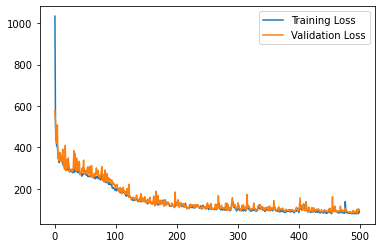

In [37]:
seed = 0
batch_size = 64
epochs = 500

np.random.seed(seed)
cvae = CVAE()
model = cvae.cvae()
model.summary()
model.add_loss(cvae.loss())

np.random.seed(seed)
model.compile(optimizer='adam', loss=None)
history = model.fit([X_train, y_train[:,0], y_train[:,0]], epochs=epochs, batch_size=batch_size, validation_data=([X_test, y_test[:,0], y_test[:,0]], None))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

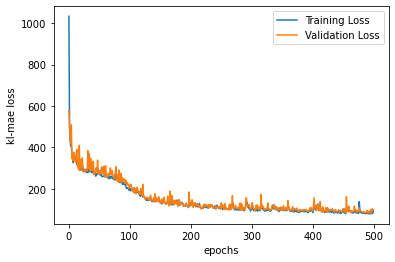

In [38]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("epochs")
plt.ylabel("kl-mae loss")
plt.legend()

<class 'numpy.ndarray'> (15, 30)
<class 'numpy.ndarray'> (15, 30)
<class 'numpy.ndarray'> (450, 1)
<class 'numpy.ndarray'> (450, 1)


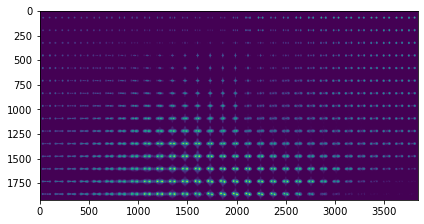

In [15]:
ndiv = 30 # number of images for axis
tem = 15
gx = np.linspace(-3, 4, ndiv)
l = np.linspace(30,160, tem)
gxx, gyy = np.meshgrid(gx, l[::-1])
print(type(gxx),gxx.shape)
print(type(gyy),gyy.shape)
gxx = gxx.reshape(-1,1)
gyy = gyy.reshape(-1,1)
print(type(gxx),gxx.shape)
print(type(gyy),gyy.shape)
dec = cvae.decoder()
x = dec.predict([gxx,gyy])
dst = x.reshape(tem,ndiv,128,128)
dst = dst.transpose(0,2,1,3)
dst = dst.reshape(tem*128, ndiv*128)
# plot images
plt.imshow(dst)
plt.tight_layout();plt.show()
#save png
out = (cm.inferno(dst)[:,:,:3]*255).astype(np.uint8)
skio.imsave('cvae_out_%03d.png' % 22, out)

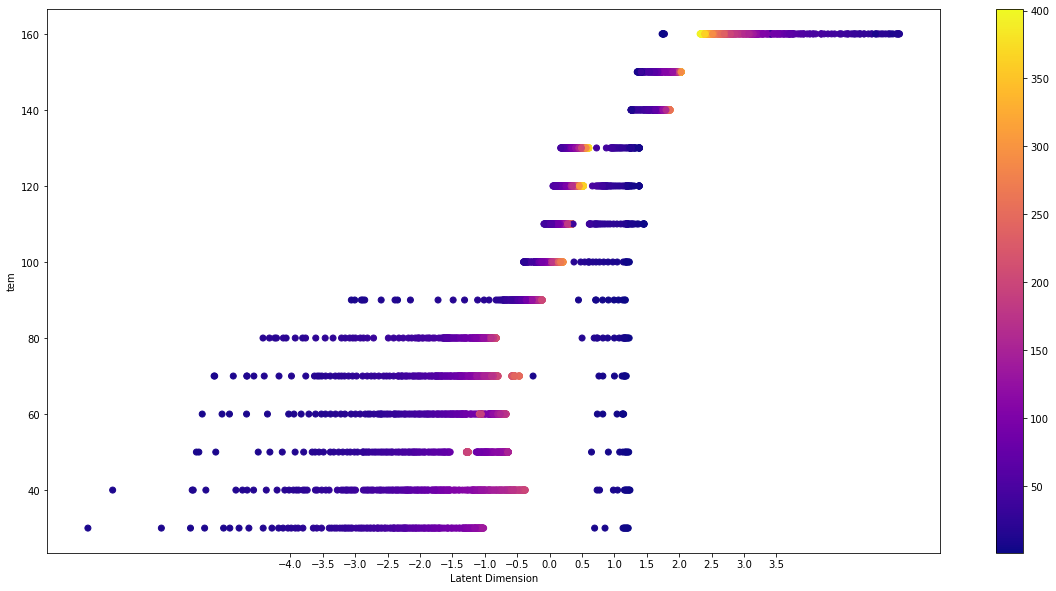

In [39]:
enc = cvae.encoder()
plot_digits(X_train, y_train[:,0], y_train[:,1], enc)  # y for label coloring 

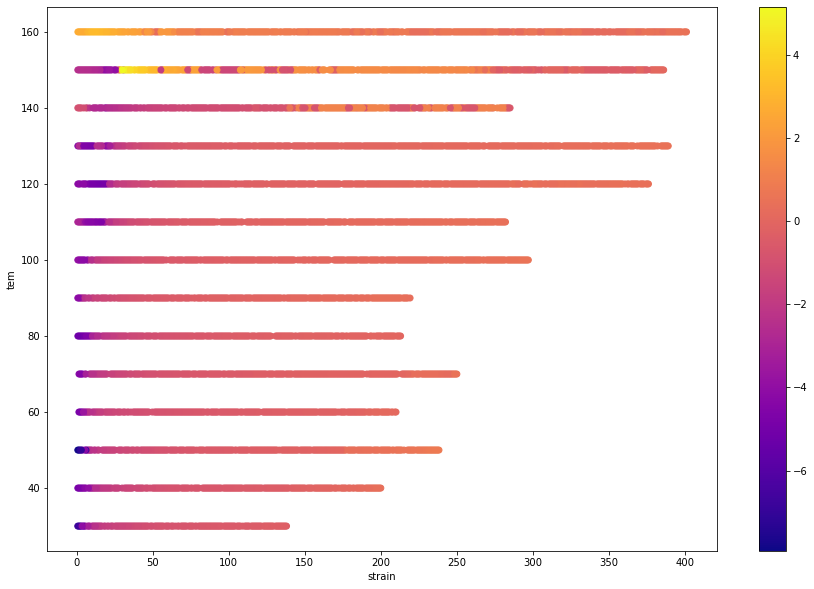

In [12]:
plot_digits1(y_train[:,1], y_train[:,0], X_train, enc)  # y for label coloring 

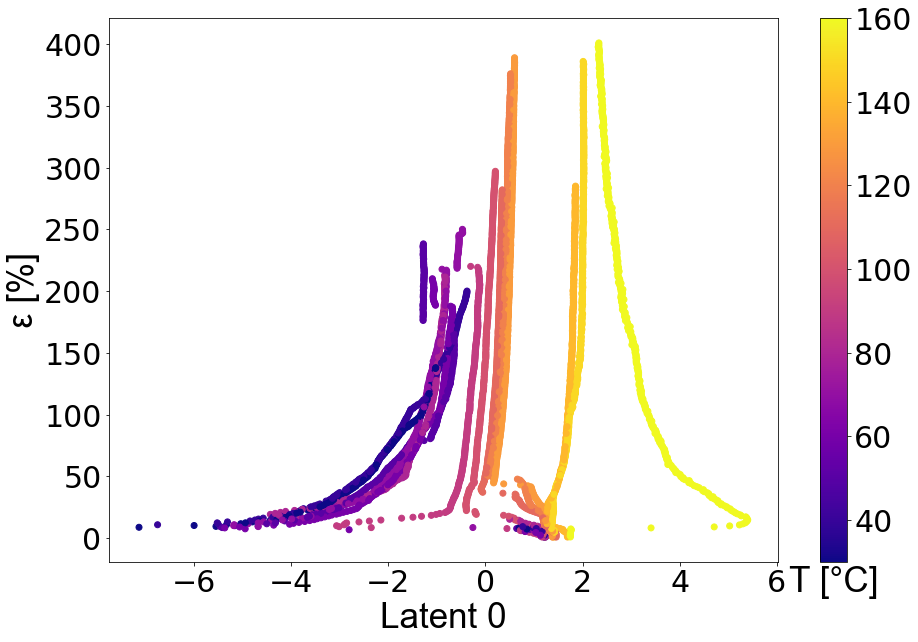

In [46]:
def plot_digits2(X, s, y, encoder):
    """Plots labels and MNIST digits as function of 2D latent vector

    Parameters:
    ----------
    encoder: Model
        A Keras Model instance
    X: np.ndarray
        Test data
    y: np.ndarray
        Test data labels
    batch_size: int
        Prediction batch size
    """
    # display a 2D plot of the digit classes in the latent space
    z_mean = encoder.predict([X,y])
    plt.figure(figsize=(15, 10))
    plt.scatter(z_mean, s, c = y,cmap = 'plasma')
    cb=plt.colorbar()
    cb.ax.tick_params(labelsize=30)
    cb.ax.set_xlabel('T [°C]', size=35,fontproperties="Arial")
    plt.xlabel("Latent 0",fontsize = 35,fontproperties="Arial")
    plt.ylabel("ε [%]",fontsize = 35,fontproperties="Arial")
    plt.xticks(fontsize = 30)
    plt.yticks(fontsize = 30)
    plt.savefig(r"C:\Users\zch\Desktop\7.4\数据整理\文章用图\2")
    plt.show()
plot_digits2(X_train, y_train[:,1], y_train[:,0], enc)

<class 'numpy.ndarray'> (1, 1)
<class 'numpy.ndarray'> (1, 14)
<class 'numpy.ndarray'> (1, 14)
<class 'numpy.ndarray'> (14, 1)
<class 'numpy.ndarray'> (14, 1)


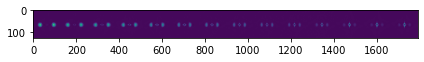

In [22]:
ndiv = 14 # number of images for axis
tem = 1
gx = np.linspace(0.4,-0.5, ndiv)
l = [[150]]
l = np.array(l)
print(type(l),l.shape)
gxx, gyy = np.meshgrid(gx, l[::-1])
print(type(gxx),gxx.shape)
print(type(gyy),gyy.shape)
gxx = gxx.reshape(-1,1)
gyy = gyy.reshape(-1,1)
print(type(gxx),gxx.shape)
print(type(gyy),gyy.shape)
dec = cvae.decoder()
x = dec.predict([gxx,gyy])
dst = x.reshape(tem,ndiv,128,128)
dst = dst.transpose(0,2,1,3)
dst = dst.reshape(tem*128, ndiv*128)
# plot images
plt.imshow(dst)
plt.tight_layout();plt.show()
#save png
out = (cm.inferno(dst)[:,:,:3]*255).astype(np.uint8)
skio.imsave('cvae_out_%03d.png' % 150, out)

In [ ]:
dec = cvae.decoder()
# plot images
dst = Perdict_tem(t, s, a, b, decoder)
#save png
out = (cm.inferno(dst)[:,:,:3]*255).astype(np.uint8)
skio.imsave('cvae_out_%03d.png' % 120, out)

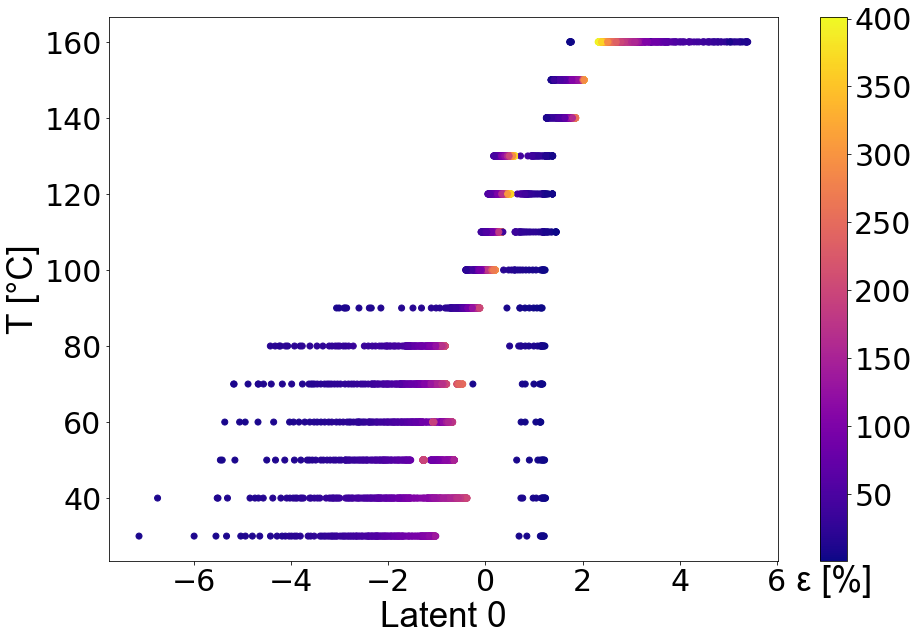

In [45]:
def plot_digits(X, y, s, encoder):
    """Plots labels and MNIST digits as function of 2D latent vector

    Parameters:
    ----------
    encoder: Model
        A Keras Model instance
    X: np.ndarray
        Test data
    y: np.ndarray
        Test data labels
    batch_size: int
        Prediction batch size
    """
    # display a 2D plot of the digit classes in the latent space
    z_mean = encoder.predict([X,y])
    plt.figure(figsize=(15, 10))
    #plt.title("distribution graph",fontsize = 30)
    plt.scatter(z_mean, y, c = s,cmap = 'plasma')
    cb=plt.colorbar()
    cb.ax.set_xlabel('ε [%]', size=35,fontproperties="Arial")
    cb.ax.tick_params(labelsize=30)
    plt.xlabel("Latent 0",fontsize = 35,fontproperties="Arial")
    plt.ylabel("T [°C]",fontsize = 35,fontproperties="Arial")
    plt.xticks(fontsize = 30)
    plt.yticks(fontsize = 30)
    plt.savefig(r"C:\Users\zch\Desktop\7.4\数据整理\文章用图\1")
    plt.show()
plot_digits(X_train, y_train[:,0], y_train[:,1], enc)  # y for label coloring 

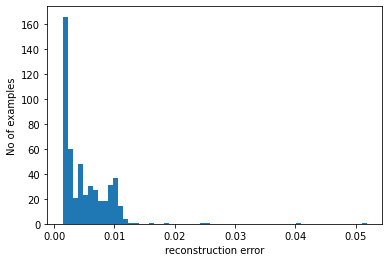

In [32]:
reconstructions = model.predict([X_test, y_test[:,0], y_test[:,0]])
train_loss = tf.keras.losses.mae(reconstructions, X_test)

plt.hist(train_loss[None,:], bins=60)
plt.xlabel("reconstruction error")
plt.ylabel("No of examples")
#plt.savefig(r"C:\Users\zch\Desktop\7.4\数据整理\文章用图\2\123")
plt.show()

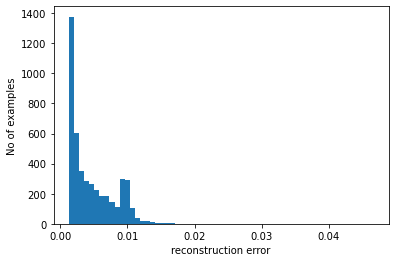

In [31]:
reconstructions = model.predict([X_train, y_train[:,0], y_train[:,0]])
train_loss = tf.keras.losses.mae(reconstructions, X_train)

plt.hist(train_loss[None,:], bins=60)
plt.xlabel("reconstruction error")
plt.ylabel("No of examples")
plt.show()

In [2]:
import tensorflow as tf
print(tf.test.is_gpu_available())

RuntimeError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory